# S-NN's
The introduction notebook is quite "fat" - lots of content for general NN's and how they work, but what we want to do is start progressing towards S-NN's. Because we're speaking in broader and broader terms - we will start squashing some concepts we explicitly broke up in the previous notebook, for example when loading data in, we will transform it directly and lazily define a `Dataloader` over top of this to handle the mini-batch GD that is to come.

In [4]:
from torchvision import datasets, transforms
import torch

batch_size = 2**6

transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])


train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

## Notes
As you can see we immediately go through the mini-batch dataloader instantiation with the MNIST's, but we also perform normalisation as in place as we load data into our runtime. It's a little more performant.

Also note;

### Normalisation (and defining our S-NN inputs)
Look how we diverge a little here with our normalization approach. We instead turn the intensity of each image pixel into a raw percentage intensity. We do this in preparation of a temporal encoding of the data... the most easy to understand encoding style would be a **rate encoding of sorts**... or explained; for each input neuron corresponding to a pixel, we'll want to convert the normalized pixel intensity to a firing rate relative to a observation window. If the intensity of a pixel is at 100% for example, we'd want the respective neuron firing every step through the observation window. Note; there are various other encodings we could experiment with. [Here is a list from ssntorch](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html#snntorch.spikegen.rate).

# Encoding
`snntorch` provides some utilities here to visualise the encodings of images, and if you've come from `NN-introduction` you've seen traditional encodings of images. Here is what a rate encoding would look like;

Cannot view this in GitHub... sorry.


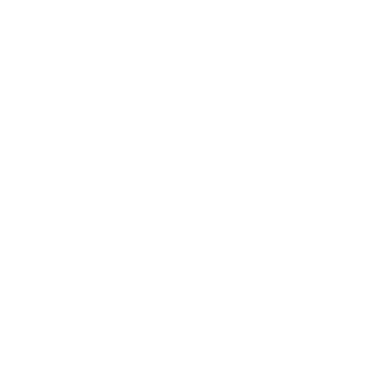

In [5]:
from snntorch import spikegen
from IPython.display import HTML
import snntorch.spikeplot as splt
import matplotlib.pyplot as plt

batches = iter(train_loader)
batch, _ = next(batches)

observation_window = 25
spike_train = spikegen.rate(batch, num_steps=observation_window)

sample = spike_train[:, 0, 0]

print("Cannot view this in GitHub... sorry.")

fig, ax = plt.subplots()
anim = splt.animator(sample, fig, ax)
HTML(anim.to_html5_video())

# Model (Replacing activation functions with LIF)
Leaky, integrate and fire neuron has the following charactersistics that correspond to each of the three parts;
- This neuron is stateful and at each step,
- The neuron **integrates** new built up input on top of it's existing state
- At each step, some of this build up is **leaked** out
- And when the neurons internal state after these two changes have happened, **fire** if the internal state built up over a threshold.

We also need to define a **observation window** which defines how many steps we should allow for this NN to express itself to the incoming **spike train**, the resulting product of a temporal encoding of the image.

In [3]:
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import spikegen

decay_rate = 0.9  # leaky part (decay)

class SimpleSNN(nn.Module):
    def __init__(self):
        super(SimpleSNN, self).__init__()

        self.fc1 = nn.Linear(28*28, 2**8)
        self.lif1 = snn.LIF(beta=decay_rate)
        self.fc2 = nn.Linear(2**8, 10)

        self.observation_window = observation_window

    def forward(self, x):
        self.lif1.init_leaky()  # reset internal state

        spike_train = spikegen.rate(x, num_steps=self.observation_window)
        spike_train = self.fc1(spike_train)
        spike_train = self.lif1(spike_train)
        spike_train = self.fc2(spike_train)

        return spike_train


model = SimpleSNN()